## Let's make the concact operation faster

In [76]:
import json 
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Define the relative path to the daily_production data folder
loc_bru = os.path.join("data", "daily_production", "BRU")
loc_sto = os.path.join("data", "daily_production", "STO")

# Define a function that reads the JSON files and populates the DataFrame
def read_json_files(loc):
    
    data_list = list()
    
    # Iterate over each file in the folder
    for filename in os.listdir(loc):
        if filename.endswith('.json'):
            file_path = os.path.join(loc, filename)
            
            # Read the JSON file
            with open(file_path, 'r') as file:
                data = json.load(file)
                
            # Append the data to data_list
            data_list.append(data)
    
    # Convert the list of dictionaries to a dataframe
    df = pd.DataFrame(data_list)
    
    return df

# Read JSON files and populate the DataFrame
df_bru = read_json_files(loc_bru)
df_sto = read_json_files(loc_sto)
display(df_bru)
display(df_sto)


,DoW,hour,minute,date,maintenance,prod_loss,prod_loss_perc,production
0,Tuesday,1,0,09-22-2020 00:00:00.0000,No,225,18,1019
1,Monday,1,0,01-22-2018 00:00:00.0000,No,255,20,989
2,Wednesday,1,0,08-21-2019 00:00:00.0000,No,138,11,1106
3,Tuesday,1,0,08-21-2018 00:00:00.0000,No,302,24,942
4,Wednesday,1,0,09-22-2021 00:00:00.0000,No,211,17,1033
...,...,...,...,...,...,...,...,...
1825,Friday,1,0,07-29-2022 00:00:00.0000,No,157,13,1087
1826,Monday,1,0,07-20-2020 00:00:00.0000,No,289,23,955
1827,Sunday,1,0,06-23-2019 00:00:00.0000,No,140,11,1104
1828,Saturday,1,0,06-23-2018 00:00:00.0000,No,204,16,1040


,DoW,hour,minute,date,maintenance,prod_loss,prod_loss_perc,production
0,Tuesday,1,0,09-22-2020 00:00:00.0000,No,85,31,189
1,Monday,1,0,01-22-2018 00:00:00.0000,No,51,19,223
2,Wednesday,1,0,08-21-2019 00:00:00.0000,No,110,40,164
3,Tuesday,1,0,08-21-2018 00:00:00.0000,Yes,#MV,#MV,#MV
4,Wednesday,1,0,09-22-2021 00:00:00.0000,No,134,49,140
...,...,...,...,...,...,...,...,...
1825,Friday,1,0,07-29-2022 00:00:00.0000,No,274,100,0
1826,Monday,1,0,07-20-2020 00:00:00.0000,No,81,29,193
1827,Sunday,1,0,06-23-2019 00:00:00.0000,No,72,26,202
1828,Saturday,1,0,06-23-2018 00:00:00.0000,No,77,28,197


## Define useful functions and variable mapping

In [77]:
from dateutil import parser

def convert_date(date_str): 
    return pd.to_datetime(date_str, format='%m-%d-%Y %H:%M:%S.%f')

def clean_data(dataframe):

    dataframe['date'] = convert_date(dataframe['date'])
    dataframe['hour'] = pd.to_datetime(dataframe['hour'].astype(str), format='%H').dt.hour
    dataframe['minute'] = pd.to_datetime(dataframe['minute'].astype(str), format='%M').dt.minute
    dataframe['DoW'] = dataframe['DoW'].apply(lambda x: parser.parse(x).strftime("%A"))

    dataframe['prod_loss_perc'] = dataframe['prod_loss_perc'].replace('#MV', np.nan).astype(float)
    dataframe['prod_loss'] = dataframe['prod_loss'].replace('#MV', np.nan).astype(float)
    dataframe['production'] = dataframe['production'].replace('#MV', np.nan).astype(float)
    dataframe = dataframe.sort_values(by='date')
    dataframe = dataframe.reset_index(drop=True)
    return dataframe

df_bru = clean_data(df_bru)
df_sto = clean_data(df_sto)
display(df_bru)
display(df_sto)


,DoW,hour,minute,date,maintenance,prod_loss,prod_loss_perc,production
0,Monday,1,0,2018-01-01,No,61.0,5.0,1183.0
1,Tuesday,1,0,2018-01-02,No,106.0,9.0,1138.0
2,Wednesday,1,0,2018-01-03,No,129.0,10.0,1115.0
3,Thursday,1,0,2018-01-04,No,278.0,22.0,966.0
4,Friday,1,0,2018-01-05,No,218.0,17.0,1026.0
...,...,...,...,...,...,...,...,...
1825,Saturday,1,0,2022-12-31,No,203.0,16.0,1041.0
1826,Sunday,1,0,2023-01-01,No,231.0,19.0,1013.0
1827,Monday,1,0,2023-01-02,No,181.0,15.0,1063.0
1828,Tuesday,1,0,2023-01-03,No,198.0,16.0,1046.0


,DoW,hour,minute,date,maintenance,prod_loss,prod_loss_perc,production
0,Monday,1,0,2018-01-01,No,9.0,3.0,265.0
1,Tuesday,1,0,2018-01-02,No,9.0,3.0,265.0
2,Wednesday,1,0,2018-01-03,No,18.0,6.0,256.0
3,Thursday,1,0,2018-01-04,No,22.0,8.0,252.0
4,Friday,1,0,2018-01-05,No,31.0,11.0,243.0
...,...,...,...,...,...,...,...,...
1825,Saturday,1,0,2022-12-31,No,51.0,19.0,223.0
1826,Sunday,1,0,2023-01-01,No,53.0,20.0,221.0
1827,Monday,1,0,2023-01-02,No,61.0,22.0,213.0
1828,Tuesday,1,0,2023-01-03,No,70.0,25.0,204.0


## Write the restults to excel (currently optional)

In [78]:
import pandas as pd

# Define the folder path to save the excel files
folder_path = os.path.join("data")

# Write the df_stu DataFrame to an excel file
df_bru.to_excel(os.path.join(folder_path, 'df_bru.xlsx'), index=False)

# Write the df_sto DataFrame to an excel file
df_sto.to_excel(os.path.join(folder_path, 'df_sto.xlsx'), index=False)

## Let's plot our raw data including NaN and zero values

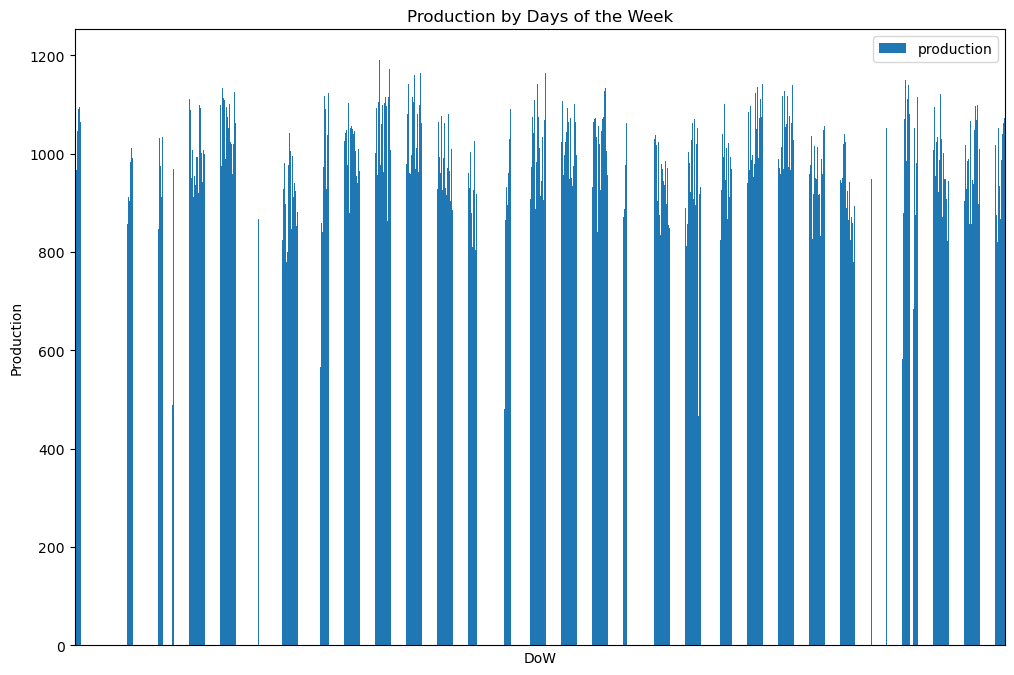

In [79]:
import matplotlib.pyplot as plt

# Plot DataFrame
df_bru.plot(kind='bar', x='DoW', y='production', figsize=(12, 8))

# Add labels
plt.ylabel('Production')
plt.title('Production by Days of the Week')
plt.xticks([])
# Show plot
plt.show()

## Aggregatie per maand (met maintenance inbegrepen)

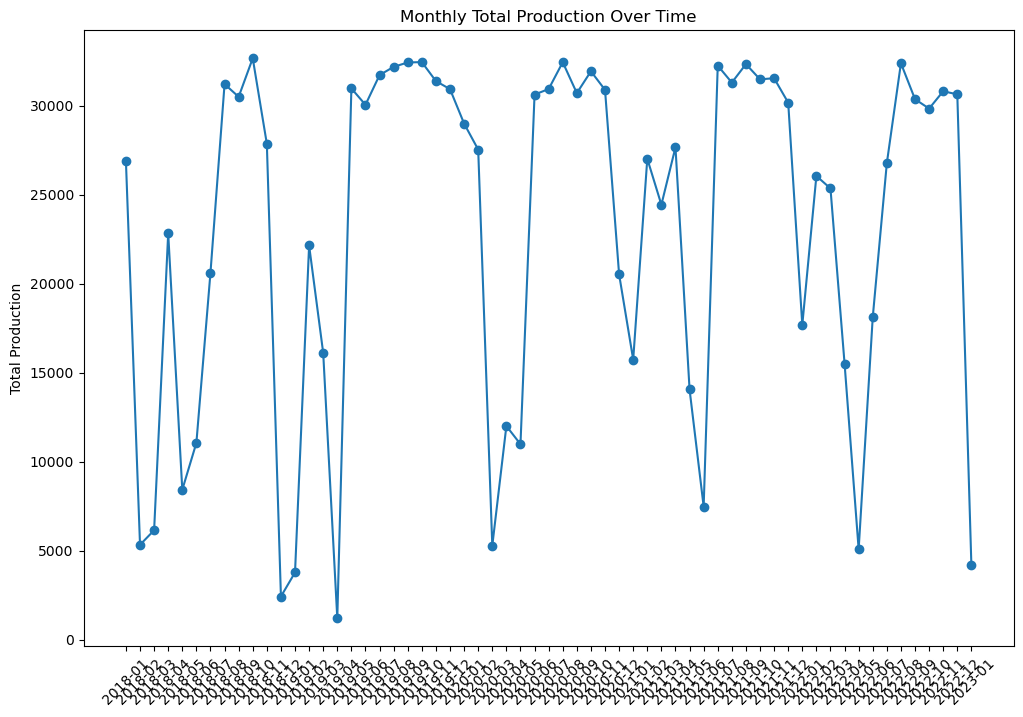

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df_bru' is your DataFrame and 'date' needs to be converted to datetime
df_bru['date'] = pd.to_datetime(df_bru['date'])

# Extract year and month
df_bru['Year'] = df_bru['date'].dt.year
df_bru['Month'] = df_bru['date'].dt.month

# Create a pivot table
pivot_table = df_bru.pivot_table(values='production', index=['Year', 'Month'], aggfunc='sum')

# Flatten the pivot table index for easier plotting
pivot_table.reset_index(inplace=True)

# Create a new column for year-month
pivot_table['Year-Month'] = pivot_table.apply(lambda row: f"{int(row['Year'])}-{int(row['Month']):02d}", axis=1)

# Plot
plt.figure(figsize=(12, 8))
plt.plot(pivot_table['Year-Month'], pivot_table['production'], marker='o')
plt.xticks(rotation=45)
plt.ylabel('Total Production')
plt.title('Monthly Total Production Over Time')
plt.show()


## Aggregatie per maand zonder maintenance-dagen om uitschieters te vermijden

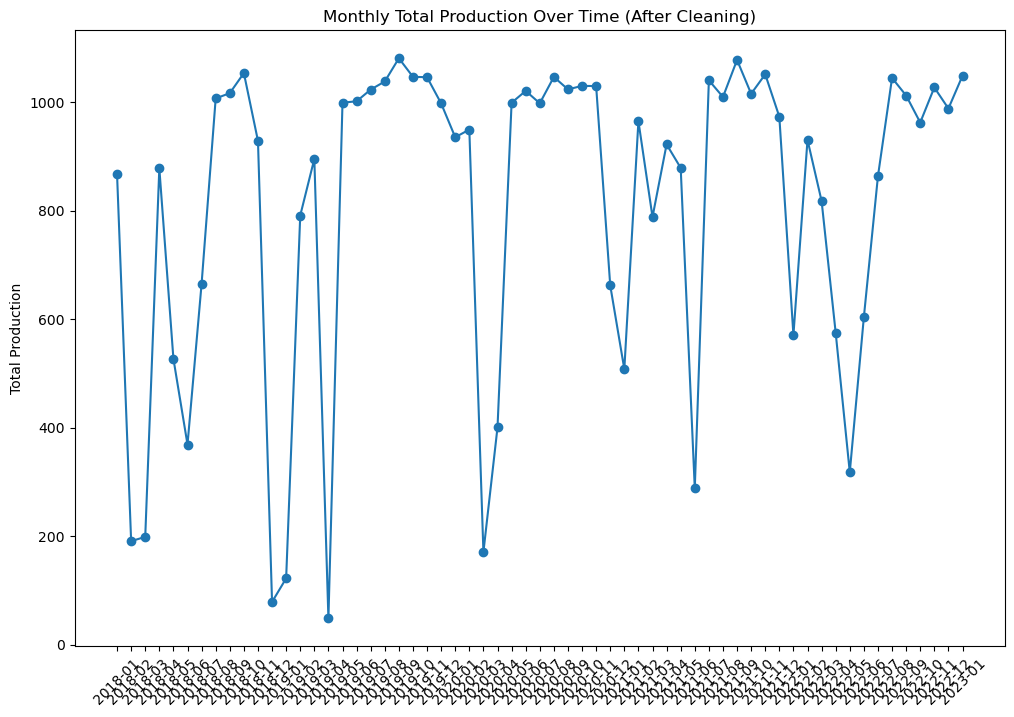

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Remove all rows where the df_bru.maintenance column has a value 'Yes'
df_bru_cleaned = df_bru[df_bru['maintenance'] != 'Yes'].copy()

# 2. Remove all NaN values
df_bru_cleaned.dropna(inplace=True)

# Convert 'date' to datetime if it's not already
df_bru_cleaned['date'] = pd.to_datetime(df_bru_cleaned['date'])

# Extract year and month
df_bru_cleaned['Year'] = df_bru_cleaned['date'].dt.year
df_bru_cleaned['Month'] = df_bru_cleaned['date'].dt.month

# Create a pivot table
pivot_table = df_bru_cleaned.pivot_table(values='production', index=['Year', 'Month'], aggfunc='mean')

# Flatten the pivot table index for easier plotting
pivot_table.reset_index(inplace=True)

# Create a new column for year-month
pivot_table['Year-Month'] = pivot_table.apply(lambda row: f"{int(row['Year'])}-{int(row['Month']):02d}", axis=1)

# 3. Plot
plt.figure(figsize=(12, 8))
plt.plot(pivot_table['Year-Month'], pivot_table['production'], marker='o')
plt.xticks(rotation=45)
plt.ylabel('Total Production')
plt.title('Monthly Total Production Over Time (After Cleaning)')
plt.show()


## Let's plot STO data and exclude NaN and zero values

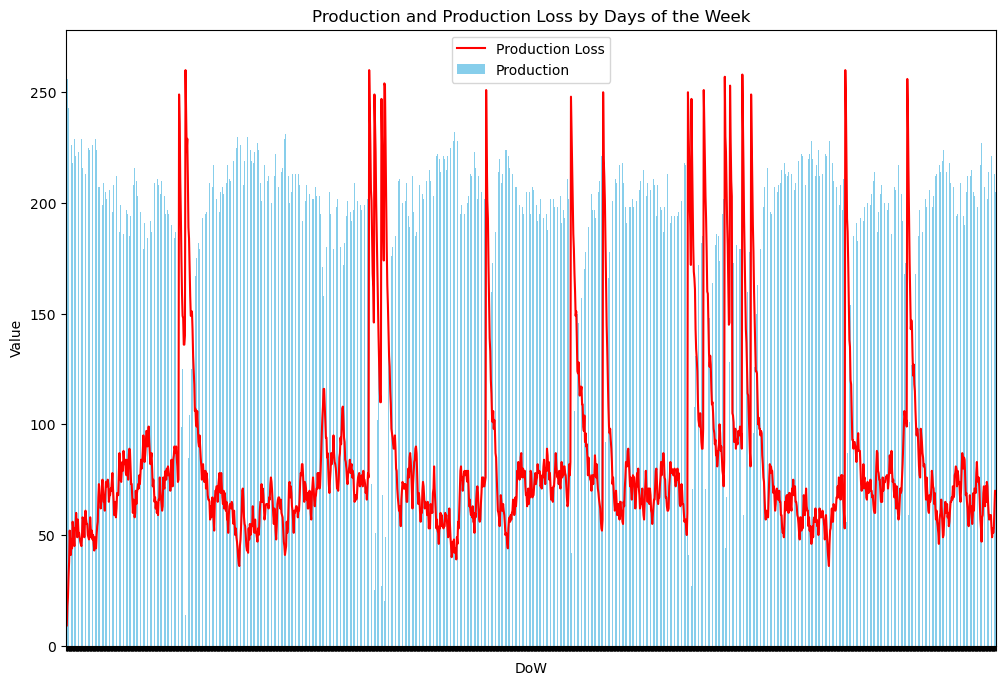

In [82]:
import matplotlib.pyplot as plt

# Assuming `df_sto` is your DataFrame
# Remove rows with NaN values in either 'production' or 'prod_loss' columns
df_sto_clean = df_sto[df_sto['production'] > 0]
df_sto_clean = df_sto_clean.dropna(subset=['prod_loss'])

# Create a bar chart for 'production'
ax = df_sto_clean.plot(kind='bar', x='DoW', y='production', figsize=(12, 8), color='skyblue', label='Production')

# Create a line chart for 'prod_loss' on top of the bar chart
df_sto_clean.plot(kind='line', x='DoW', y='prod_loss', color='red',ax=ax, label='Production Loss')

# Optionally, you can hide the x-axis labels if they are not needed
ax.set_xticklabels([])  # Hides x-axis labels

# Set the labels and title
ax.set_xlabel('DoW')
ax.set_ylabel('Value')
ax.set_title('Production and Production Loss by Days of the Week')

# Add a legend to distinguish the two charts
ax.legend()

plt.show()


## Let's do the same for BRU

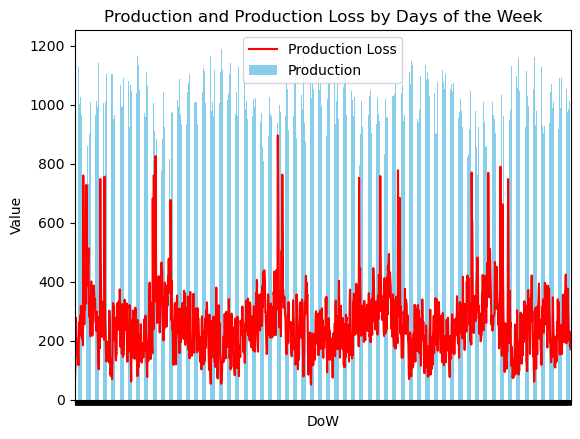

In [83]:
import matplotlib.pyplot as plt

# Assuming `df_bru` is your DataFrame
# Remove rows with NaN values in either 'production' or 'prod_loss' columns
df_bru_clean = df_bru[df_bru['production'] > 0]
df_bru_clean = df_bru_clean.dropna(subset=['prod_loss'])

# Create a bar chart for 'production'
ax = df_bru_clean.plot(kind='bar', x='DoW', y='production', color='skyblue', label='Production')

# Create a line chart for 'prod_loss' on top of the bar chart
df_bru_clean.plot(kind='line', x='DoW', y='prod_loss', color='red',ax=ax, label='Production Loss')

# Optionally, you can hide the x-axis labels if they are not needed
ax.set_xticklabels([])  # Hides x-axis labels

# Set the labels and title
ax.set_xlabel('DoW')
ax.set_ylabel('Value')
ax.set_title('Production and Production Loss by Days of the Week')

# Add a legend to distinguish the two charts
ax.legend()

plt.show()


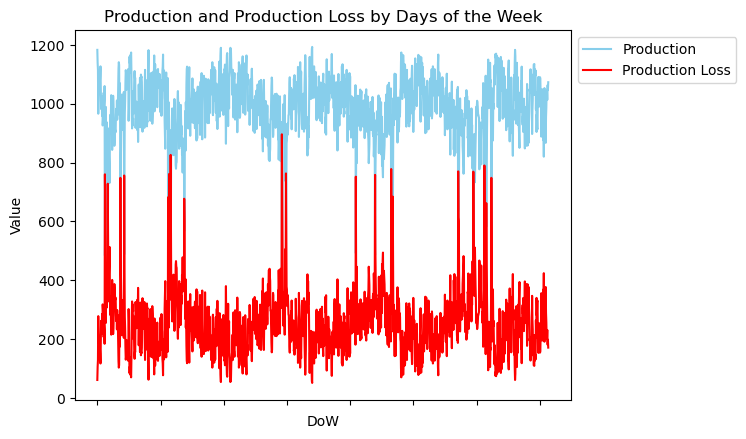

In [84]:
import matplotlib.pyplot as plt

# Assuming `df_bru` is your DataFrame
# Remove rows with NaN values in either 'production' or 'prod_loss' columns
df_bru_clean = df_bru[df_bru['production'] > 0]
df_bru_clean = df_bru_clean.dropna(subset=['prod_loss'])

# Create a bar chart for 'production'
ax = df_bru_clean.plot(kind='line', x='DoW', y='production', color='skyblue', label='Production')

# Create a line chart for 'prod_loss' on top of the bar chart
df_bru_clean.plot(kind='line', x='DoW', y='prod_loss', color='red',ax=ax, label='Production Loss')

# Optionally, you can hide the x-axis labels if they are not needed
ax.set_xticklabels([])  # Hides x-axis labels

# Set the labels and title
ax.set_xlabel('DoW')
ax.set_ylabel('Value')
ax.set_title('Production and Production Loss by Days of the Week')

# Add a legend to distinguish the two charts
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


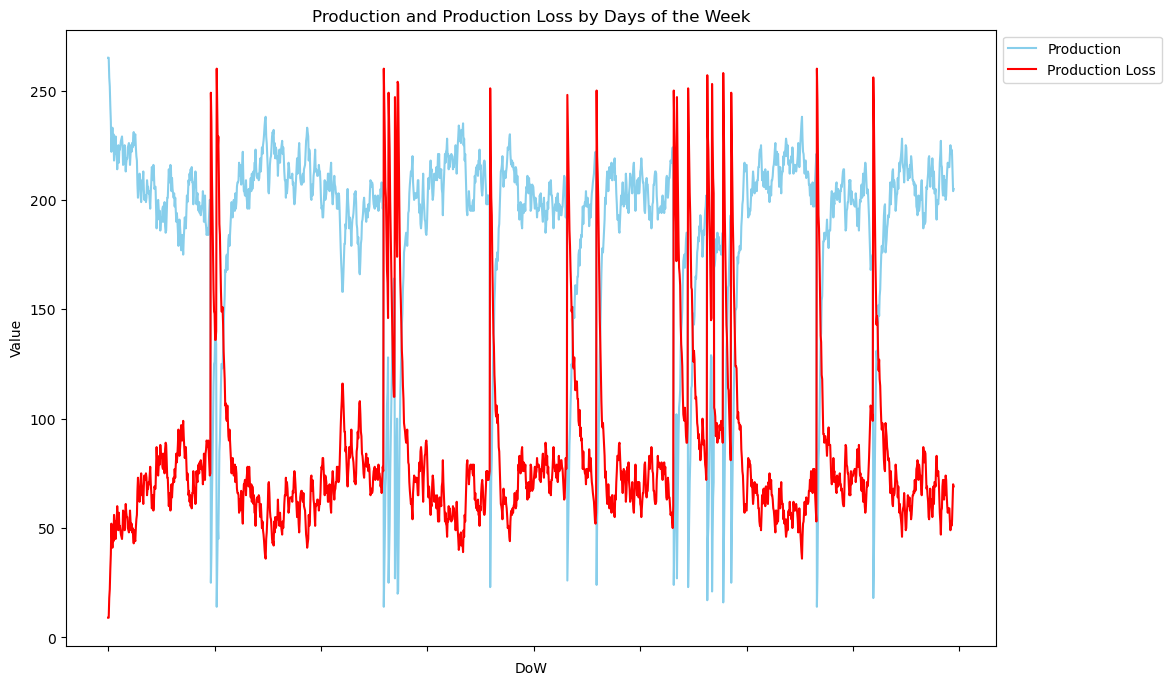

In [85]:
import matplotlib.pyplot as plt

# Remove rows with NaN values in either 'production' or 'prod_loss' columns
df_sto_clean = df_sto[df_sto['production'] > 0]
df_sto_clean = df_sto_clean.dropna(subset=['prod_loss'])

# Create a bar chart for 'production'
ax = df_sto_clean.plot(kind='line', x='DoW', y='production', figsize=(12, 8), color='skyblue', label='Production')

# Create a line chart for 'prod_loss' on top of the bar chart
df_sto_clean.plot(kind='line', x='DoW', y='prod_loss', color='red',ax=ax, label='Production Loss')

# Optionally, you can hide the x-axis labels if they are not needed
ax.set_xticklabels([])  # Hides x-axis labels

# Set the labels and title
ax.set_xlabel('DoW')
ax.set_ylabel('Value')
ax.set_title('Production and Production Loss by Days of the Week')

# Add a legend to distinguish the two charts
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


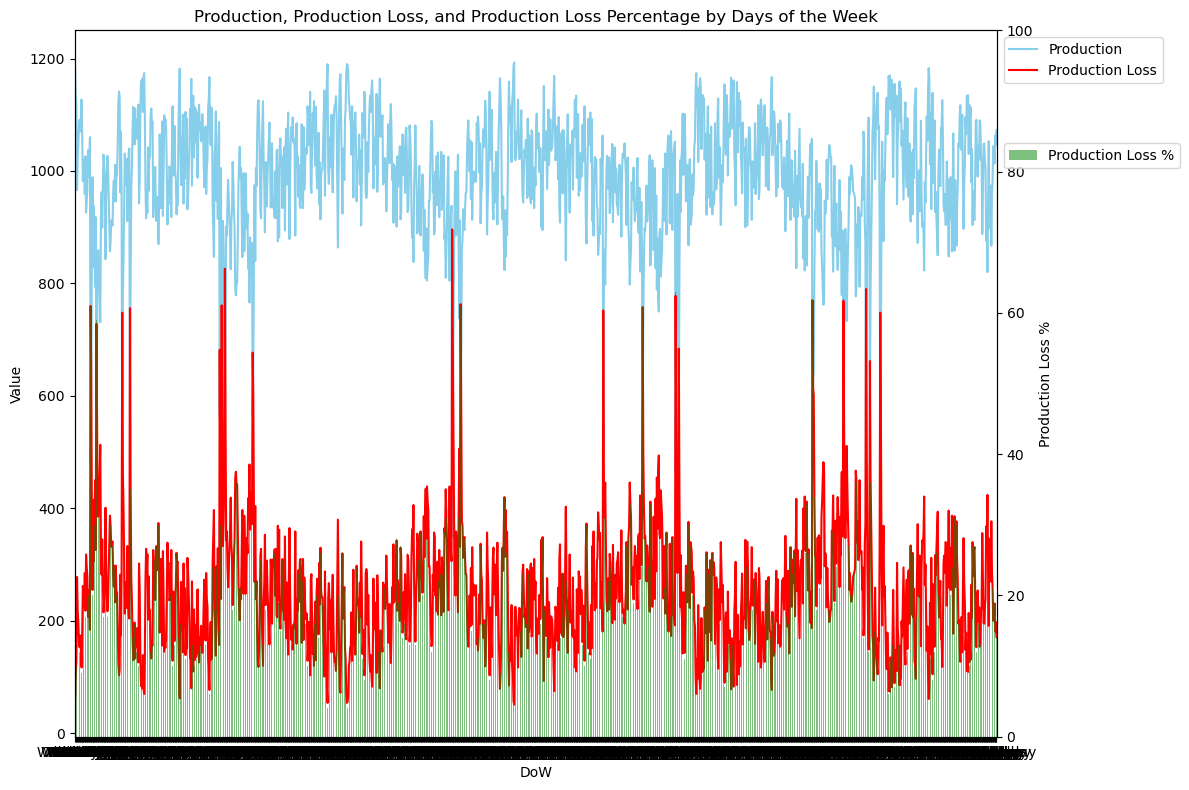

In [86]:
import matplotlib.pyplot as plt

# Assuming `df_bru` is your DataFrame
# Remove rows with NaN values in either 'production' or 'prod_loss' columns
df_bru_clean = df_bru[df_bru['production'] > 0]
df_bru_clean = df_bru_clean.dropna(subset=['prod_loss'])

# Create the figure and the primary axis
fig, ax1 = plt.subplots(figsize=(12, 8))

# Create a line chart for 'production' on the primary axis
df_bru_clean.plot(kind='line', x='DoW', y='production', color='skyblue', label='Production', ax=ax1)

# Create a line chart for 'prod_loss' on the primary axis
df_bru_clean.plot(kind='line', x='DoW', y='prod_loss', color='red', ax=ax1, label='Production Loss')

# Set primary y-axis labels and title
ax1.set_xlabel('DoW')
ax1.set_ylabel('Value')
ax1.set_title('Production, Production Loss, and Production Loss Percentage by Days of the Week')

# Hide the x-axis labels to reduce clutter
ax1.set_xticklabels([])

# Create a secondary axis for the bar chart
ax2 = ax1.twinx()

# Create a bar chart for 'prod_loss_perc' on the secondary axis
df_bru_clean.plot(kind='bar', x='DoW', y='prod_loss_perc', color='green', ax=ax2, label='Production Loss %', alpha=0.5)

# Set secondary y-axis limit to 100% and label
ax2.set_ylim(0, 100)
ax2.set_ylabel('Production Loss %')

# Add legend for the primary axis
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Add legend for the secondary axis
ax2.legend(loc='upper left', bbox_to_anchor=(1, 0.85))

# Adjust layout
plt.tight_layout()

# Show the final plot
plt.show()


## Code snippet for fitting a distribution (for later)

In [108]:
import numpy as np
from scipy import stats

def find_best_fit_distribution_continuous(data, distributions=None):
    """
    Find the best-fit distribution for the given data.

    Parameters:
        data (array-like): The data to fit the distributions to.
        distributions (list, optional): The candidate distributions to consider.
            Defaults to [stats.norm, stats.gamma, stats.expon, stats.uniform].

    Returns:
        best_distribution_bru (scipy.stats.rv_continuous): The best-fit distribution.
        best_params_bru (tuple): The parameters of the best-fit distribution.
    """
    if distributions is None:
        distributions = [
            stats.norm,      # Normal distribution
            stats.gamma,     # Gamma distribution
            stats.expon,     # Exponential distribution
            stats.uniform    # Uniform distribution
        ]

    best_distribution = None
    best_params = {}
    best_sse = np.inf

    for distribution in distributions:
        params = distribution.fit(data)
        sse = np.sum((distribution.pdf(data, *params) - data) ** 2)

        if sse < best_sse:
            best_distribution = distribution
            best_params = params
            best_sse = sse

    return best_distribution, best_params

def main():
    # Generate sample data
    np.random.seed(0)
    values = np.random.normal(loc=0, scale=1, size=1000)
    
    bru_pro = df_bru_clean['production'].copy()
    sto_pro = df_sto_clean['production'].copy()

    # Find the best-fit distribution
    best_distribution_bru, best_params_bru = find_best_fit_distribution_continuous(bru_pro)
    best_distribution_sto, best_params_sto = find_best_fit_distribution_continuous(sto_pro)

    # Print the best-fit distribution and its parameters
    print(f"Best-fit distribution for Brussels: {best_distribution_bru.name}")
    print(f"Parameters for Brussels: {best_params_bru}")
    
    print(f"Best-fit distribution for Stockholm: {best_distribution_sto.name}")
    print(f"Parameters: {best_params_sto}")

if __name__ == '__main__':
    main()

Best-fit distribution for Brussels: norm
Parameters for Brussels: (989.218487394958, 108.90790262811456)
Best-fit distribution for Stockholm: norm
Parameters: (190.9679245283019, 40.17786996986101)


## Probeersel om alle niet-maintenance dagen te extraheren

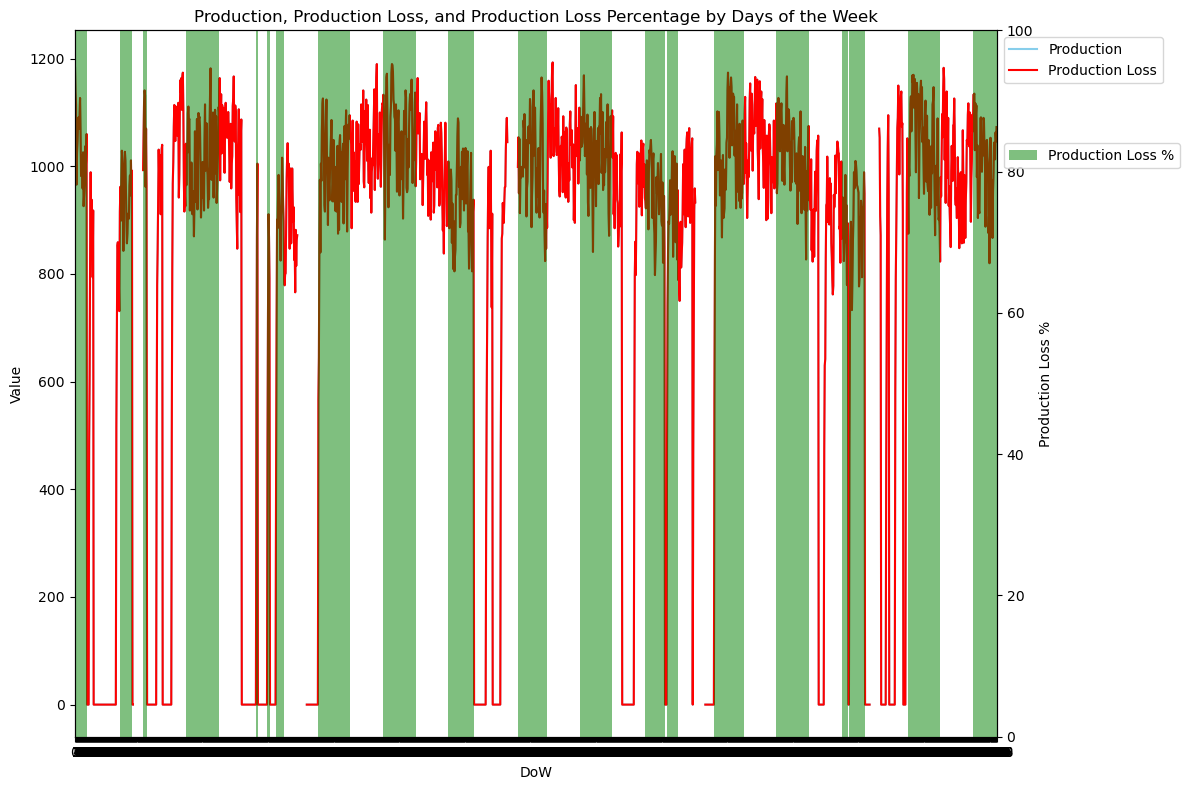

In [88]:
import matplotlib.pyplot as plt

# Assuming `df_bru` is your DataFrame
# Remove rows with NaN values in either 'production' or 'prod_loss' columns
df_bru_test= df_bru[df_bru['maintenance'] == 'No']
df_bru_test = df_bru['production']
                              
# Create the figure and the primary axis
fig, ax1 = plt.subplots(figsize=(12, 8))

# Create a line chart for 'production' on the primary axis
df_bru_test.plot(kind='line', x='DoW', y='production', color='skyblue', label='Production', ax=ax1)

# Create a line chart for 'prod_loss' on the primary axis
df_bru_test.plot(kind='line', x='DoW', y='prod_loss', color='red', ax=ax1, label='Production Loss')

# Set primary y-axis labels and title
ax1.set_xlabel('DoW')
ax1.set_ylabel('Value')
ax1.set_title('Production, Production Loss, and Production Loss Percentage by Days of the Week')

# Hide the x-axis labels to reduce clutter
ax1.set_xticklabels([])

# Create a secondary axis for the bar chart
ax2 = ax1.twinx()

# Create a bar chart for 'prod_loss_perc' on the secondary axis
df_bru_test.plot(kind='bar', x='DoW', y='prod_loss_perc', color='green', ax=ax2, label='Production Loss %', alpha=0.5)

# Set secondary y-axis limit to 100% and label
ax2.set_ylim(0, 100)
ax2.set_ylabel('Production Loss %')

# Add legend for the primary axis
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Add legend for the secondary axis
ax2.legend(loc='upper left', bbox_to_anchor=(1, 0.85))

# Adjust layout
plt.tight_layout()

# Show the final plot
plt.show()


## Manuele vergelijking met mijn distributiemodel

In [89]:
df_bru.describe()

,hour,minute,date,prod_loss,prod_loss_perc,production,Year,Month
count,1830.0,1830.0,1830,1736.000000,1736.000000,1736.000000,1830.000000,1830.000000
mean,1.0,0.0,2020-07-03 12:00:00,430.288018,34.579493,813.711982,2020.006557,6.511475
min,1.0,0.0,2018-01-01 00:00:00,51.000000,4.000000,0.000000,2018.000000,1.000000
25%,1.0,0.0,2019-04-03 06:00:00,196.750000,16.000000,860.750000,2019.000000,4.000000
50%,1.0,0.0,2020-07-03 12:00:00,270.500000,22.000000,973.500000,2020.000000,7.000000
75%,1.0,0.0,2021-10-03 18:00:00,383.250000,31.000000,1047.250000,2021.000000,10.000000
max,1.0,0.0,2023-01-04 00:00:00,1244.000000,100.000000,1193.000000,2023.000000,12.000000
std,0.0,0.0,NaN,390.712496,31.413713,390.712496,1.419601,3.455351


In [105]:
# Create a copy of df_bru and drop NaN values
test_bru = df_bru.dropna().copy()

# Drop rows where production is equal to 0
test_bru = test_bru[test_bru['production'] != 0]

# Display descriptive statistics for the modified DataFrame
test_bru.describe()



,hour,minute,date,prod_loss,prod_loss_perc,production,Year,Month
count,1428.0,1428.0,1428,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000
mean,1.0,0.0,2020-08-28 03:16:38.319327744,254.781513,20.469188,989.218487,2020.116246,7.022409
min,1.0,0.0,2018-01-01 00:00:00,51.000000,4.000000,348.000000,2018.000000,1.000000
25%,1.0,0.0,2019-07-19 18:00:00,181.000000,15.000000,935.750000,2019.000000,4.000000
50%,1.0,0.0,2020-09-08 12:00:00,242.000000,19.000000,1002.000000,2020.000000,8.000000
75%,1.0,0.0,2021-11-05 06:00:00,308.250000,25.000000,1063.000000,2021.000000,10.000000
max,1.0,0.0,2023-01-04 00:00:00,896.000000,72.000000,1193.000000,2023.000000,12.000000
std,0.0,0.0,NaN,108.946056,8.764922,108.946056,1.379778,3.416773


In [109]:
print(test_bru['production'].median())
print(test_bru['production'].mean())
print(test_bru['production'].min())
print(test_bru['production'].max())
print(test_bru['production'].std())
test_bru.head()


1002.0
989.218487394958
348.0
1193.0
108.94605568678305


,DoW,hour,minute,date,maintenance,prod_loss,prod_loss_perc,production,Year,Month
0,Monday,1,0,2018-01-01,No,61.0,5.0,1183.0,2018,1
1,Tuesday,1,0,2018-01-02,No,106.0,9.0,1138.0,2018,1
2,Wednesday,1,0,2018-01-03,No,129.0,10.0,1115.0,2018,1
3,Thursday,1,0,2018-01-04,No,278.0,22.0,966.0,2018,1
4,Friday,1,0,2018-01-05,No,218.0,17.0,1026.0,2018,1


In [114]:

# Create a pivot table to sum production by year and month
pivot_table = test_bru.pivot_table(values='production', index='Year', columns='Month', aggfunc=['mean', 'std'], fill_value=0)

# Display the pivot table
print(pivot_table)
pivot_table.describe()

              mean                                                   \
Month           1           2           3           4            5    
Year                                                                  
2018    995.407407  889.833333  769.250000  951.416667  1053.875000   
2019    756.600000  886.000000  895.388889  605.500000   999.129032   
2020    935.387097  949.517241  755.142857  857.857143   999.000000   
2021    925.941176  965.071429  905.148148  922.233333   937.533333   
2022    884.350000  930.571429  874.275862  912.882353   847.166667   
2023   1048.750000    0.000000    0.000000    0.000000     0.000000   

                                                                        ...  \
Month           6            7            8            9            10  ...   
Year                                                                    ...   
2018    922.000000  1031.050000  1006.935484  1016.666667  1053.709677  ...   
2019   1001.700000  1023.290323  1038.193548

mean                                                   \
Month           1           2           3           4            5    
count     6.000000    6.000000    6.000000    6.000000     6.000000   
mean    924.405947  770.165572  699.867626  708.314916   806.117339   
std     100.388155  378.623388  348.846914  369.147990   401.153703   
min     756.600000    0.000000    0.000000    0.000000     0.000000   
25%     894.747794  886.958333  758.669643  668.589286   869.758333   
50%     930.664137  910.202381  821.762931  885.369748   968.266667   
75%     980.402330  944.780788  890.110632  919.895588   999.096774   
max    1048.750000  965.071429  905.148148  951.416667  1053.875000   

                                                                        ...  \
Month           6            7            8            9            10  ...   
count     6.000000     6.000000     6.000000     6.000000     6.000000  ...   
mean    814.466204   853.755852   857.677419   868.577778   851.451613  ...   
std     401.032920   418.498758   420.531637   426.611156   418.383783  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%     925.468750  1004.322581  1007.612903  1013.366667   975.798387  ...   
50%     968.787500  1026.549007  1023.919355  1020.150000  1022.838710  ...   
75%    1005.216667  1030.739423  1043.080645  1064.333333  1042.612903  ...   
max    1020.833333  1040.387097  1046.580645  1081.000000  1053.709677  ...   

              std                                                             \
Month          3           4           5           6           7          8    
count    6.000000    6.000000    6.000000    6.000000    6.000000   6.000000   
mean   106.731344   67.954451  100.345677  100.808637   92.282645  58.367778   
std     76.136735   47.532825   81.531884   67.383509   58.703582  29.329643   
min      0.000000    0.000000    0.000000    0.000000    0.000000   0.000000   
25%     75.476436   53.907132   65.684245   65.320795   67.528811  64.182247   
50%    108.024708   60.696026   74.592868  105.364052   92.241468  66.747927   
75%    123.481780   82.632879  138.419838  153.200961  138.927587  70.081721   
max    231.077497  144.745324  230.478126  173.004077  155.432048  82.190809   

                                                    
Month         9          10         11          12  
count   6.000000   6.000000   6.000000    6.000000  
mean   61.807872  56.009157  55.488769   81.200259  
std    32.785524  27.781052  29.000742   76.346048  
min     0.000000   0.000000   0.000000    0.000000  
25%    61.530942  61.793687  55.290397   54.840492  
50%    67.138076  66.011980  61.064422   65.410960  
75%    78.047431  70.143659  74.174496   75.135559  
max    95.225298  72.122506  78.893526  226.685538  

[8 rows x 24 columns]

In [107]:
print(test_bru['prod_loss'].median())
print(test_bru['prod_loss'].mean())
print(test_bru['prod_loss'].min())
print(test_bru['prod_loss'].max())
print(test_bru['prod_loss'].std())

242.0
254.78151260504202
51.0
896.0


## Defining the CDF function

In [121]:
import numpy as np
from scipy.stats import norm

def cumulative_distribution_function(xx):
    """
    Calculate the cumulative distribution function for a normal distribution.

    Parameters:
    xx (array-like): An array of values for which to calculate the CDF.

    Returns:
    array: An array of CDF values.
    """
    # Assume a normal distribution (as an example)
    # You can adjust mean (loc) and standard deviation (scale) as needed
    mean = 890  # Example mean
    std_dev = 108  # Example standard deviation

    # Calculate the CDF for each value in xx
    cdf_values = norm.cdf(xx, loc=mean, scale=std_dev)

    return cdf_values

# Example usage
xx = np.linspace(0, 1200)
cdf_values = cumulative_distribution_function(xx)

# Print or process the CDF values as needed
print(cdf_values)

[8.55738624e-17 5.55258650e-16 3.42481844e-15 2.00809867e-14
 1.11932569e-13 5.93160218e-13 2.98850235e-12 1.43161109e-11
 6.52097187e-11 2.82451420e-10 1.16345710e-09 4.55791453e-09
 1.69835539e-08 6.01975479e-08 2.02984292e-07 6.51223378e-07
 1.98809718e-06 5.77627579e-06 1.59746348e-05 4.20596090e-05
 1.05448218e-04 2.51798359e-04 5.72821661e-04 1.24184588e-03
 2.56652083e-03 5.05847096e-03 9.51228625e-03 1.70751830e-02
 2.92765223e-02 4.79786249e-02 7.52142391e-02 1.12897450e-01
 1.62433658e-01 2.24301066e-01 2.97712794e-01 3.80475267e-01
 4.69122666e-01 5.59334415e-01 6.46556162e-01 7.26678020e-01
 7.96604515e-01 8.54587018e-01 9.00266010e-01 9.34456105e-01
 9.58769645e-01 9.75196712e-01 9.85741444e-01 9.92172388e-01
 9.95898681e-01 9.97950044e-01]


In [126]:
import numpy as np
from scipy import stats

def find_best_fit_distribution_continuous(data, distributions=None):
    """
    Find the best-fit distribution for the given data.

    Parameters:
        data (array-like): The data to fit the distributions to.
        distributions (list, optional): The candidate distributions to consider.
            Defaults to [stats.norm, stats.gamma, stats.expon, stats.uniform].

    Returns:
        best_distribution (scipy.stats.rv_continuous): The best-fit distribution.
        best_params (tuple): The parameters of the best-fit distribution.
    """
    if distributions is None:
        distributions = [
            stats.norm,      # Normal distribution
            stats.gamma,     # Gamma distribution
            stats.expon,     # Exponential distribution
            stats.uniform    # Uniform distribution
        ]

    best_distribution = None
    best_params = {}
    best_sse = np.inf

    for distribution in distributions:
        params = distribution.fit(data)
        sse = np.sum((distribution.pdf(data, *params) - data) ** 2)

        if sse < best_sse:
            best_distribution = distribution
            best_params = params
            best_sse = sse

    return best_distribution, best_params

def main():
    # Generate sample data
    np.random.seed(0)
    values = np.random.normal(loc=0, scale=1, size=1000)
    
    brussels_production = df_bru_clean['production'].copy()
    stockholm_production = df_sto_clean['production'].copy()

    # Find the best-fit distribution
    best_distribution_brussels, best_params_brussels = find_best_fit_distribution_continuous(brussels_production)
    best_distribution_stockholm, best_params_stockholm = find_best_fit_distribution_continuous(stockholm_production)

    # Create a DataFrame to display the results
    data = {
        'Location': ['Brussels', 'Stockholm'],
        'Best-fit Distribution': [best_distribution_brussels.name, best_distribution_stockholm.name],
        'Parameters': [best_params_brussels, best_params_stockholm]
    }
    df = pd.DataFrame(data)

    # Print the results in a user-friendly format
    print(df)
    
if __name__ == '__main__':
    main()

    Location Best-fit Distribution                              Parameters
0   Brussels                  norm  (989.218487394958, 108.90790262811456)
1  Stockholm                  norm  (190.9679245283019, 40.17786996986101)
